# Quickstart
A few examples are given for calculating the steady-state probability distribution for master equations with finite states analytically (compared to a Gillespie simulation).
Furthermore, this notebook shows how to calculate the entropy production (analytical mean and simulated distribution).
For the molecular motor (parametrisation by Liepelt and Lipowsky 2007), the steady-state probability and entropy production are calculated. Distributions for the velocity and the entropy production of this systems are calculated from simulatios.


In [1]:
import numpy as np

from matplotlib import pyplot as plt
import math

import time
import random
import networkx as nx
import os

import sys
path='Bibliotheken/'
res2 = os.listdir(path)
print(res2)
sys.path.append(path)

import Steady_State_Calculation_Spanning_Trees as auto
import Kinesin_Parameters as Kinesin
import PDF_Flux_entropy as PDF
import Analytic_Quantities as analytic

['Steady_State_Calculation_Spanning_Trees.py', 'Kinesin_Parameters.py', 'Analytic_Quantities.py', 'PDF_Flux_entropy.py', 'Bib3_version4b.py', '__pycache__']


# steady-state probability distribution

We consider discrete stochastic systems described by a master equation. The system has N discrete states and tran-
sition between states i and j occur with time-independent transition rates $a_{ij}$. At a certain time t, a state i is occupied with probability $p_i(t)$ which evolves according to a master equation.
We can calculate the steady-state by representing the states and transitions as the nodes and edges of a graph (Schnakenberg 1976).

Here, we consider a matrix $A$ with entries $a_{ij}$ as rates for transition $i \rightarrow j$. The diagonal elements $a_{ii}$ are zero. The example system has 4 states. The first 3 form a 3-state cycle. The 4th state is connected via a bridge to the the 3rd state.

We use the library "Steady_State_Calculation_Spanning_Trees" to transform the adjacency matrix $A$ into a corresponding Graph $G$. The function "steady_state" calculates the steady-state by calculating the "weight" of all spanning trees. For large systems, calculating all spanning trees is expensive.

In [2]:
A = np.array([[0,1,1,0], [1,0,1,0], [1,1,0,1], [0,0,1,0]])
print('A = \n', A)
G=auto.Matrix2Graph(A)
p=auto.steady_state(G)
print('steady state p = ',p)

A = 
 [[0 1 1 0]
 [1 0 1 0]
 [1 1 0 1]
 [0 0 1 0]]
steady state p =  [0.25 0.25 0.25 0.25]


All transition rates are equal in the example above. All fluxes are zero (detailed balance) and hence the system is in equilibrium. 

We now change the transition rates such that the system is in an non-equilibirium steady-state.

In [3]:
A = np.array([[0,2,3,0], [0.5,0,0.1,0], [1,1,0,0.5], [0,0,1,0]])
print('A = \n', A)
G = auto.Matrix2Graph(A)
p = auto.steady_state(G)
print('steady state p = ',p)

A = 
 [[0.  2.  3.  0. ]
 [0.5 0.  0.1 0. ]
 [1.  1.  0.  0.5]
 [0.  0.  1.  0. ]]
steady state p =  [0.0990991  0.63063063 0.18018018 0.09009009]


# Entropy production
All nonzero fluxes are associated with the production of entropy. The total entropy production $P$ can be expressed in terms of the net-transition fluxes $J_{ij}$ and the corresponding transition affinities $\Delta S_{ij}$. The transition affinity quantifies the change of entropy associated with a transition.
The entropy production can be used to quantify the deviation from detailed balance for nonequilibrium systems.

In [4]:
P = analytic.entropyProduction(matrix=A, p=p)
print('Entropy production P =',P)

P1=dS/dt= -1.249000902703301e-16
P2(copling to set of thermodynamic forces)= 0.2359796330364816
Entropy production P = 0.23597963303648145


# Molecular motor kinesin - parametrisation

Kinesin is a motor protein with two heads which can carry cargo, moves along microtubule filaments, and is powered
by the hydrolysis of adenosine triphosphate (ATP).Kinesin can be described by a six-states network. The six states correspond to different chemical states of the two motor heads (ATP or ADP bound or free). Transition 2 → 5 corresponds to a mechanical forward step, the backward transition 5 → 2 to a backward step (see Liepelt and Lipowsky (2007) for more information).

In [5]:
[w, w1]=Kinesin.Kinesin(force=1.e-12)
G=auto.Matrix2Graph(w)
p=auto.steady_state(G)
print('Adjacency matrix for kinesin motor A = \n', w)
print('steady state p =',p)

Adjacency matrix for kinesin motor A = 
 [[0.00000000e+00 1.35914641e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.90008325e-02]
 [7.55081338e+01 0.00000000e+00 1.90008325e+02 0.00000000e+00
  1.64643491e+05 0.00000000e+00]
 [0.00000000e+00 8.55037463e-02 0.00000000e+00 1.90008325e+02
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.90008325e-02 0.00000000e+00
  1.35914641e+00 0.00000000e+00]
 [0.00000000e+00 9.73247992e-01 0.00000000e+00 4.83252056e-11
  0.00000000e+00 1.90008325e+02]
 [1.90008325e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.55037463e-02 0.00000000e+00]]
steady state p = [9.84661814e-01 8.15695405e-06 8.26721580e-06 1.13982003e-03
 7.04334417e-03 7.13859798e-03]


# Gillespie simulations
Trajectories can be simulated with a Gillespie algorithm. Relaxation into the steady state or dwell time distributions can be investigated. The exit rate $\lambda_i$ is the sum over all outgoing rates from state $i$. 
First, the exponentially distributed dwell time will be simulated by drawing a random variable $z_1$ from a uniform distribution between zero and one. The transformation 
\begin{align}
dt=-\dfrac{1}{\lambda_i}\ln (z_1) 
\end{align}
yields the waiting time in state $i$ before the next transition.
To determine which transition will happen, one draws another random variable $z_2$ and checks in which interval $z_2$ falls, where
\begin{align}
I_j=\left[ \dfrac{1}{\lambda_i}\sum_{k=0}^{j-1} a_{ik} ,\dfrac{1}{ \lambda_i}\sum_{k=0}^{j} a_{ik} \right).
\end{align}
If $z_2 \in I_j$ the transition from state $i$ to state $j$ will be simulated.

In [6]:
# Relaxation into steady state for large T
p_sim = PDF.simulation_prob(matrix=w, startState=1, T=10000)
print('simulated probability for Kinesin system,  p = ', p_sim)

simulated probability for Kinesin system,  p =  [9.85350476e-01 8.27672368e-06 7.21214023e-06 4.01632436e-04
 7.07503075e-03 7.18484734e-03]


# Distribution of entropy production
See FIG4_Distribution_Entropy_Prod_Velocity.ipynb for more

We consider the distribution for the entropy production for trajectories of length 1200\,s. For a trajectory of duration $\tau$ with $m$ transitions $n_0\rightarrow n_1 \rightarrow ... \rightarrow n_{m-1} \rightarrow n_m$ we consider the quantity 
\begin{align}
P_{\tau}=\dfrac{k_B}{\tau}\ln \dfrac{\alpha_{ n_1}\alpha_{ n_2} ...\alpha _{n_{m-1}n_m}}{\alpha _{n_1 n_0}\alpha _{n_2 n_1} ...\alpha _{n_{m}n_{m-1}} }
\label{eq:entropy_prod_trajectory}
\end{align}
as entropy production as proposed by Lebowitz and Spohn.

In [7]:
runtime = 1200.0 # for each trajectory
Trajectories = 10000
start_time = time.time()
# simulate certain number of trajectories for certain time and determine the entropy production of every run
vec = PDF.pdf_entropy(Matrix=w, start=0, time=runtime, runs=Trajectories)
print("--- %s seconds ---" % (time.time() - start_time))

--- 335.2091510295868 seconds ---


maximum and minimum value of simulated entropy production
[36.745119778508, 30.51065129466717]


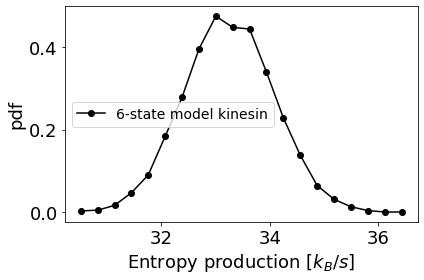

In [8]:
vec = np.array(vec)
MAX = np.max(vec)
MIN = np.min(vec)
print('maximum and minimum value of simulated entropy production')
print([MAX, MIN])
# histrogram
[hist, bin_edges] = np.histogram(vec, density=True, bins=20)

# plot histogram
f_size = 18
fig, ax = plt.subplots()
ax.plot(bin_edges[:-1], hist, '-ok', color='black', label='6-state model kinesin')
ax.set_xlabel('Entropy production [$k_B$/$s$]', fontsize=f_size)
ax.set_ylabel('pdf', fontsize=f_size)
ax.tick_params(axis='both', labelsize=f_size)
ax.legend(prop={'size': 14})
fig.tight_layout()
plt.show()

# Distribution of velocity
See FIG4_Distribution_Entropy_Prod_Velocity.ipynb for more

We consider the velocity distribution for the 6-state model obtained from 10000 trajectories with simulation time 1200\,s. The velocity of the motor is proportional to the flux between states 2 and 5 and is given by
\begin{align}
    v = l J_{25},
\end{align}
where $l$ is the step size of the motor.
The variance of the velocity decreases for longer trajectories. 

In [34]:
runtime = 1200.0 # for each trajectory
Trajectories = 10000 # number of trajectories to simulate
i = 1 #python starts counting with 0, and the Kinesins model starts with 1
node1 = 2-i
node2 = 5-i
start_time = time.time()
# simulate certain number of trajectories for certain time and determine the entropy production of every run
[totalcounts, counts12, counts21, netcounts] = PDF.pdf_transition(Matrix=w, start=0, time=runtime, runs=Trajectories, state1=node1, state2=node2)
vec2 = np.array(netcounts)
print("--- %s seconds ---" % (time.time() - start_time))

--- 270.3273320198059 seconds ---


maximum and minimum value of simulated entropy production
[1.4533333333333334, 1.2166666666666666]


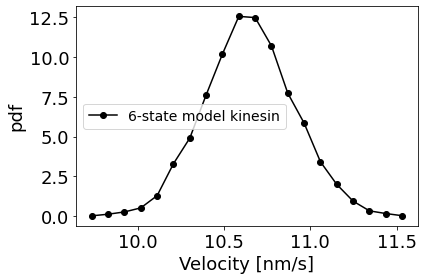

In [37]:
vec2 = np.array(vec2)
MAX = np.max(vec2)
MIN = np.min(vec2)
print('maximum and minimum value of simulated entropy production')
print([MAX, MIN])
# histrogram
[hist2, bin_edges2] = np.histogram(vec2, density=True, bins=20)

l = 8 # stepsize of kinesin motor in nm
# plot histogram
f_size = 18
fig, ax = plt.subplots()
ax.plot(l*np.array(bin_edges2[:-1]), hist2, '-ok', color='black', label='6-state model kinesin')
ax.set_xlabel('Velocity [nm/s]', fontsize=f_size)
ax.set_ylabel('pdf', fontsize=f_size)
ax.tick_params(axis='both', labelsize=f_size)
ax.legend(prop={'size': 14})
fig.tight_layout()
plt.show()